ใน ep.4 นี้เราจะมาลองสร้าง Dataset ของตัวเอง เพื่อเทรนโมเดล เราเลือกที่จะสร้างชุดข้อมูลปัญหาผิวหน้า ที่พบบ่อยในคนทั่วไป

* Acne สิว 
* Melasma ฝ้า
* Freckle กระ

เราเข้าไปที่ Google Images แล้ว Search รูปที่ต้องการ เลือกเป็น Size ใหญ่ แล้วกดปุ่ม <kbd>F12</kbd> แล้วก็อปปี้โค้ดด้านล่างไปแปะ แล้วกด <kbd>Enter</kbd>

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

เราจะได้ไฟล์ที่เก็บรายชื่อ URL ของรูปทั้งหมดในผลการค้นหา ให้เรา Save และนำมา Upload ไว้ใน Folder data/skin

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

ให้เราใส่ชื่อไฟล์แ และชื่อ Folder ให้ถูกต้องตาม Category ที่เราจะทำ Classifier ในที่นี้ เรามี 3 หมวดหมู่ คือ สิว acne, ฝ้า melasma, กระ freckle

In [3]:
folder = 'acne'
file = 'urls_acne.txt'

In [6]:
folder = 'freckle'
file = 'urls_freckle.txt'

In [9]:
folder = 'melasma'
file = 'urls_melasma.txt'

สั่งให้สร้าง Folder และ Download รูป ตาม URL ที่อยู่ในไฟล์ จำนวน max_pics = 500 รูป ไปใส่ไว้ Folder dest

*หมายเหตุ ให้เรา 1. เลือก Category ในช่องด้านบน แล้วกด Run แล้วจึง 2. มาเลือกช่องด่านล่าง สั่ง Run เพื่อ Download*

In [4]:
path = Path('data/skin')
download_path = path/'downloads'
dest = download_path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file, dest, max_pics=500, max_workers=8)

วนลูปตรวจสอบไฟล์ เนื่องจาก Google Image บอกว่ามีรูปนี้อยู่ แต่จริง ๆ รูปอาจจะไม่ได้อยู่แล้ว บางทีเราจะได้ไฟล์ขยะมาแทน delete=True คือถ้าเจอไฟล์ขยะให้ลบทิ้ง และให้ย่อรูปให้มีขนาดไม่เกิน max_size ทั้งกว้างและยาว Pixel

In [5]:
classes = ['acne', 'freckle', 'melasma']

In [ ]:
for c in classes:
    print(c)
    verify_images(download_path/c, delete=True, max_size=480)

# 3. เตรียมข้อมูล

ใน ep ก่อน ๆ เราใช้ขนาดรูปแค่ 224, 299, 28 Pixel เท่านั้น แต่ในเคสนี้ ถ้ารูปเล็กเกินไปจะทำให้เห็นแต่รูปร่างรวม ๆ ไม่เห็นผิว ไม่เห็นความผิดปกติที่เกิดขึ้นบนผิว เราจึงปรับความละเอียดของรูปที่ใช้เทรน เพิ่มเป็น 400 การปรับจูนพารามิเตอร์ของโมเดลแบบนี้ เรียกว่า Hyperparameter Tuning มีหลายตัวด้วยกัน ซึ่งเราจะอธิบายต่อไป

In [6]:
batchsize = 24
np.random.seed(42)

databunch = ImageDataBunch.from_folder(download_path, train='.', 
                                       valid_pct=0.2, 
                                       ds_tfms=get_transforms(), 
                                       size=400, bs=batchsize).normalize()

# ### อ่านให้จบ ข้อ 8 ก่อน ค่อยย้อนขึ้นมาดูใหม่
# databunch = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', 
#                                        valid_pct=0.2, 
#                                        ds_tfms=get_transforms(), 
#                                        size=400, bs=batchsize).normalize()

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [7]:
databunch.classes

['acne', 'freckle', 'melasma']

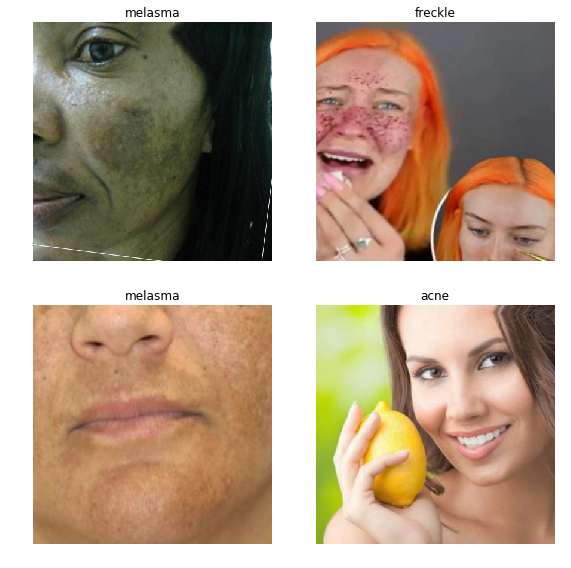

In [41]:
databunch.show_batch(rows=2, figsize=(8, 8))

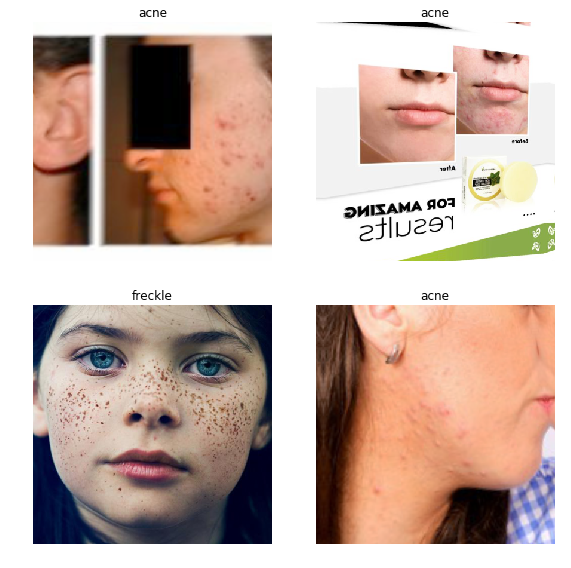

In [42]:
databunch.show_batch(rows=2, figsize=(8, 8))

In [9]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['acne', 'freckle', 'melasma'], 3, 1085, 271)

## คุณภาพของรูปจากอินเตอร์เน็ต

จะเห็นได้ว่ารูปที่ดาวน์โหลดมาจาก Google Image คุณภาพค่อนข้างหลากหลาย มีทั้งรูปสต็อก รูปศิลปะ รูปโฆษณา รูปดารา รูปผลิตภัณฑ์ รูปวิชาการ etc. แต่ไม่เป็นไรเราจะลองเทรนโมเดลด้วยรูปเหล่านี้ดู

# 4. สร้างโมเดล



In [10]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Epoch

In [11]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.975397,0.698744,0.719557,00:23
1,0.855998,0.739297,0.667897,00:18
2,0.717009,0.614015,0.774908,00:18
3,0.584072,0.599671,0.752768,00:18
4,0.543254,0.589301,0.756458,00:18
5,0.470179,0.556987,0.749077,00:18
6,0.405458,0.536361,0.782288,00:17
7,0.356590,0.543817,0.760148,00:18


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [12]:
learner.save('01d-resnet50-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [13]:
# learner.load('01d-resnet50-1')

# 6. เทรนต่อ

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [14]:
learner.unfreeze()

In [15]:
learner.fit_one_cycle(6, max_lr=slice(3e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.334730,0.541932,0.771218,00:23
1,0.342247,0.583101,0.793358,00:22
2,0.334227,0.534595,0.793358,00:22
3,0.255147,0.554595,0.782288,00:22
4,0.197303,0.508051,0.811808,00:22
5,0.155600,0.502610,0.822878,00:22


## สำเร็จแล้ว ##

เพียงแค่เวลา 7 นาทีเศษ เราเทรน Model ตามวิธีเดิม ด้วยรูปที่คุณภาพหลายหลาย จำนวนแค่ 500 x 3 = 1,500 รูป 

แต่โมเดลสามารถเรียนรู้จากรูปเท่าที่มี แยกแยะ Noise ที่ไม่เกี่ยวข้องออกไป ทำให้เราได้ accuracy ประมาณ 0.82 หรือ ความแม่นยำประมาณ 82%


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [16]:
learner.save('01d-resnet50-2')

In [17]:
# learner.load('01d-resnet50-2')

# 7. ดูผลลัพธ์

In [18]:
interpretation = ClassificationInterpretation.from_learner(learner)

## โมเดลจำแนกผิวได้ถูกต้อง

สั่งให้ plot_top_losses ด้วย largest=False คือ การแสดง record ที่ ค่า loss น้อยที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายถูกอย่างมั่นใจ 9 อันดับแรก โดยมีการแสดง heat map สีแดง ให้ดูด้วยว่า model พิจารณาเน้นจากส่วนไหนของรูปเป็นหลัก เรียกว่า Attention ที่ไว้เราจะอธิบายต่อไป

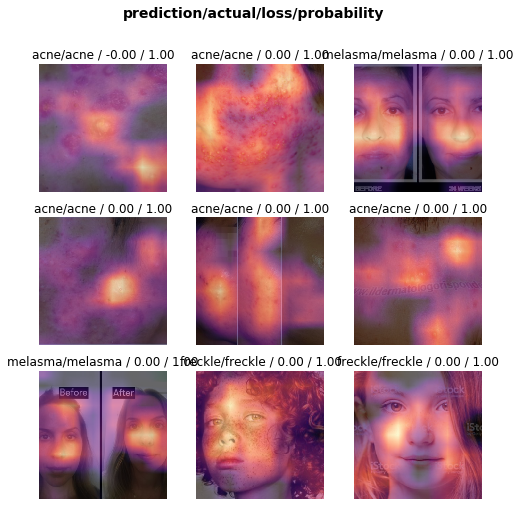

In [39]:
interpretation.plot_top_losses(9, figsize=(8, 8), largest=False)

จะเห็นได้ว่าโมเดลพิจารณาถูกจุดจริง ๆ โฟกัสตรงตำแหน่งบนใบหน้าที่เป็น สิว ฝ้า กระ ชัดเจน โดยไม่สนใจจุดที่ผิวปกติ

## โมเดลจำแนกผิว ผิดหมวด

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด 9 อันดับแรก

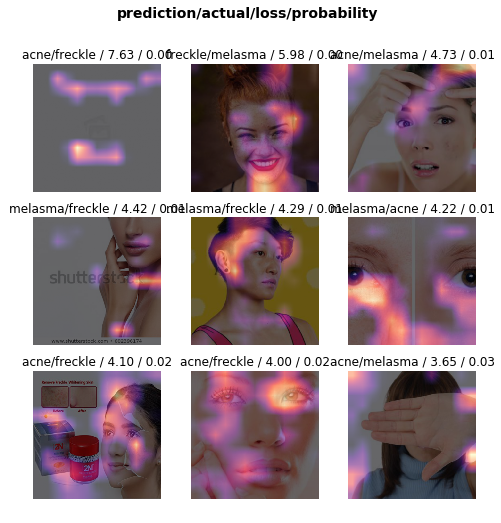

In [40]:
interpretation.plot_top_losses(9, figsize=(8, 8), largest=True)

จะเห็นได้ว่ายากจริง ๆ เนื่องจากสภาพผิวมีตั้งแต่เริ่มเกิดอาการ ไปจนถึงเป็นเรื้อรัง รูปก็มีคุณภาพหลากหลาย บางรูปก็มีป้ายโฆษณาขึ้นมาบัง

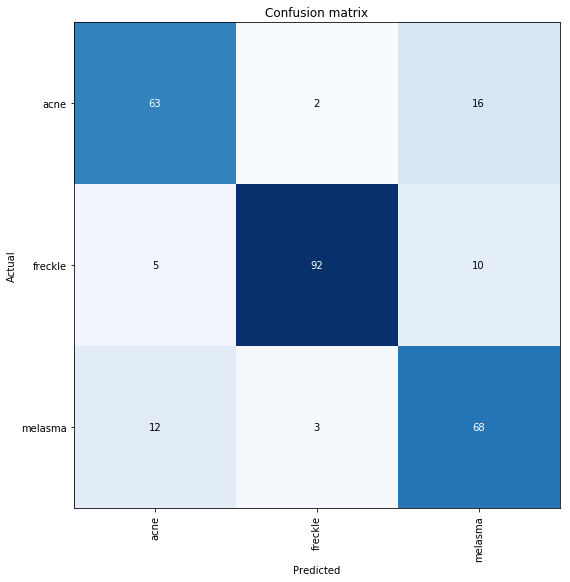

In [43]:
interpretation.plot_confusion_matrix(figsize=(8, 8), dpi=72)

เรียกดู most_confused คือ หมวดหมู่ที่โมเดลจำแนกผิดมากที่สุดเรียงลงไป

In [22]:
interpretation.most_confused(min_val=2)

[('acne', 'melasma', 16),
 ('melasma', 'acne', 12),
 ('freckle', 'melasma', 10),
 ('freckle', 'acne', 5),
 ('melasma', 'freckle', 3),
 ('acne', 'freckle', 2)]

# 8. Clean ข้อมูล แล้วลองเทรนใหม่

In [23]:
from fastai.widgets import *

เลือกรูปที่เรียงตาม Loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิดจากมากไปน้อย

In [24]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)

เปิดโปรแกรม Image Cleaner 

ให้เลือกรูปทุกรูปที่มีปัญหา กด <kbd>Delete</kbd> ใต้รูป และ กด <kbd>Next</kbd>

In [ ]:
ImageCleaner(ds, idxs, path)

รูปซ้ำก็ทำให้โมเดลมีปัญหาได้เช่นกัน ถ้ามีรูปซ้ำกันอยู่ในทั้ง Training Set และ Validation Set จะเป็นการสอนให้โมเดลจำข้อสอบ เลือกรูปที่น่าจะซ้ำมากที่สุด เรียงจากมากไปน้อย

In [25]:
ds, idxs = DatasetFormatter().from_similars(learner, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


เปิดโปรแกรม Image Cleaner 

ให้เลือกรูปทุกรูปที่มีปัญหา กด <kbd>Delete</kbd> ใต้รูป และ กด <kbd>Next</kbd>

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

## ลองเทรนใหม่

เมื่อทำเสร็จ จะเปิดไฟล์ที่ชื่อว่า cleaned.csv ขึ้นมา 

ใน [3. การเตรียมข้อมูล](#3.-%E0%B9%80%E0%B8%95%E0%B8%A3%E0%B8%B5%E0%B8%A2%E0%B8%A1%E0%B8%82%E0%B9%89%E0%B8%AD%E0%B8%A1%E0%B8%B9%E0%B8%A5) ให้เราสร้าง databunch from_csv จากไฟล์นี้แทน from_folder แล้วลองเทรนใหม่
``

# 8. สรุป


เราสามารถสร้าง Data Set ชุดข้อมูลขึ้นมาได้เอง ตามที่เราสนใจ หรือเรามีความเชี่ยวชาญ ไม่ว่าจะเป็น การแพทย์ การผลิต การเกษตร การเงิน แฟชั่น etc.

* การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน แต่ก็จะมีการทำ Hyperparameter Tuning ตามแต่ละข้อมูล
* โมเดลสามารถเอาชนะ Noise ในข้อมูลได้ระดับหนึ่ง ข้อมูลไม่จำเป็นต้อง Perfect การเสียเวลาทำให้ข้อมูล Perfect อาจจะไม่คุ้มกับ Performance ที่เพิ่มขึ้น
* เราสามารถต่อยอดโมเดลนี้ได้ อีกหลายอย่าง ไม่ว่าจะเป็น นับสิว นับกระ ระบุตำแหน่งสิว วัดขนาดฝ้า เพิ่มประเภทของโรค ไปจนถึงแนะนำการรักษาต่อไป


# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 2](https://course.fast.ai/videos/?lesson=2)